# SQL_Alchemy - Hawaii - here we come!
Congratulations! You've decided to treat yourself to a long holiday vacation in Honolulu, Hawaii! To help with your trip planning, you need to do some climate analysis on the area.


In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, select, cast

In [5]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Declare a base using automap_base
Base = automap_base()
# reflect an existing database into a new model
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
#Inspect the Measurement Table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#Inspect the Station Table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis
NOTE - the final date in the database is 23 August 2017

In [12]:
#Calculate the final date in the database
final_date = session.query(Measurement.date).order_by(sqlalchemy.desc(Measurement.date)).first()

In [13]:
#Final date check - agrees to csv
final_date

('2017-08-23')

In [14]:
ytd = timedelta(days=365)
ytd

datetime.timedelta(days=365)

In [15]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - ytd
year_ago

datetime.date(2016, 8, 23)

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
year_rain = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= year_ago).order_by(Measurement.date.desc()).all()
#print(year_rain)

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(year_rain, columns=['Date', 'Rain'])
rain_df.set_index('Date', inplace=True)
rain_df.head(10)

,Rain
Date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00
2017-08-22,0.00
2017-08-22,0.50
2017-08-21,0.00
2017-08-21,0.02


In [18]:
# Sort the dataframe by date
rain_df_sort = rain_df.sort_values(by='Date', ascending=False)
rain_df_sort.head(5)

,Rain
Date,
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-23,0.00
2017-08-22,0.00


<Figure size 864x432 with 0 Axes>

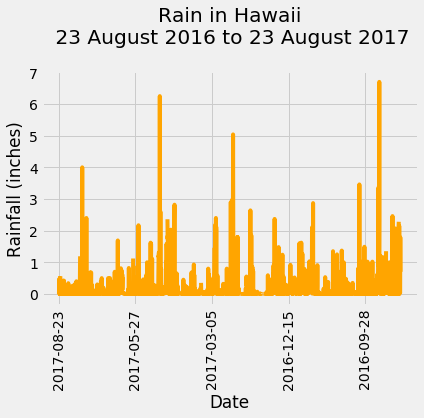

In [19]:
# Plot the data
plt.figure(figsize=(12,6))
rain_df.plot(color="orange")
plt.title('Rain in Hawaii\n 23 August 2016 to 23 August 2017\n')
plt.ylabel('Rainfall (inches)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.legend().remove()
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,Rain
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?  Count
# List the stations and the counts in descending order.
act_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
act_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
#Which station had the highest number of observations?
most_act_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
most_act_station

('USC00519281', 2772)

In [48]:
#Define the most active station from above
active_station = 'USC00519281'

In [25]:
#Identify all the names of the stations
station_names = session.query(Station.name).distinct().all()
station_names

[('WAIKIKI 717.2, HI US'),
 ('KANEOHE 838.1, HI US'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('PEARL CITY, HI US'),
 ('UPPER WAHIAWA 874.3, HI US'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('WAIHEE 837.5, HI US'),
 ('HONOLULU OBSERVATORY 702.2, HI US'),
 ('MANOA LYON ARBO 785.2, HI US')]

In [26]:
#Identify the name of the station with the highest number of observations
station_name_most_active = session.query(Station.name).filter(Station.station == active_station).all()
print(station_name_most_active)

[('WAIHEE 837.5, HI US',)]


In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station, with a chek to the number of observations?
stats_highest = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs), func.count(Measurement.tobs)).\
    filter(Measurement.station == active_station).all()

stats_highest

[(54.0, 85.0, 71.66378066378067, 2772)]

In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
temp_obs = session.query(Measurement.tobs).filter(Measurement.date >= year_ago, Measurement.station == active_station)

In [47]:
#Convert into a dataframe for plotting
temp_obs_df = pd.DataFrame(temp_obs, columns=['tobs'])

<Figure size 648x432 with 0 Axes>

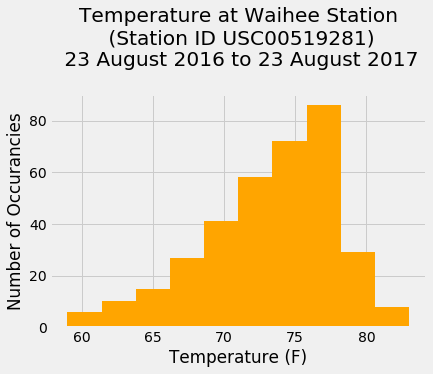

In [30]:
#plot the results as a histogram
plt.figure(figsize=(9,6))
temp_obs_df.plot.hist(color="orange")
plt.title('Temperature at Waihee Station\n (Station ID USC00519281)\n 23 August 2016 to 23 August 2017\n')
plt.ylabel('Number of Occurancies')
plt.xlabel('Temperature (F)')
plt.legend().remove()
plt.show()

## Now create a flask API based on the queries above

#### Go to python file called app_tt.py

## Bonus Challenge Assignment

In [31]:
#Define dates for use below - used right through to the end
holiday_start_date = dt.date(2014, 8, 25)
holiday_end_date = dt.date(2014, 9, 5)
holiday_start_yr_earlier = holiday_start_date - dt.timedelta(days=365)
holiday_end_yr_earlier = holiday_end_date - dt.timedelta(days=365)


In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps(holiday_start_date, holiday_end_date))

[(67.0, 76.63529411764706, 84.0)]


In [33]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
holiday_weather = calc_temps(holiday_start_yr_earlier, holiday_end_yr_earlier)
print("The tmin, tavg and tmax for the previous year, same dates, were : ", holiday_weather)

The tmin, tavg and tmax for the previous year, same dates, were :  [(66.0, 76.20430107526882, 85.0)]


#### Plot the results from your previous query as a bar chart. 
#### Use "Trip Avg Temp" as your Title
#### Use the average temperature for the y value
#### Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [34]:
#Convert to a dataframe for plotting
holiday_weather_df = pd.DataFrame(holiday_weather, columns=["tmin", "tmax", "tavg"])
holiday_weather_df

,tmin,tmax,tavg
0,66.0,76.204301,85.0


In [35]:
#Calculate the yerr (y error bar)
yerror = holiday_weather_df["tmax"] - holiday_weather_df["tmin"]
yerror

0    10.204301
dtype: float64

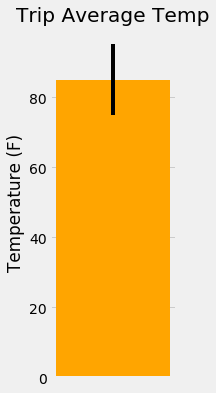

In [36]:
# Plot the results from your previous query as a bar chart. 

fig, ax = plt.subplots(figsize=(2,6))
ax.bar(1, holiday_weather_df["tavg"], yerr = yerror, color="orange")

plt.title("Trip Average Temp")
plt.xlabel("")
plt.xticks([])
plt.ylabel("Temperature (F)")
plt.show()

In [50]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall_yr = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                                  filter(Measurement.station == Station.station).\
                                  filter(Measurement.date >= holiday_start_yr_earlier).\
                                  filter(Measurement.date <= holiday_end_yr_earlier).\
                                  group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
total_rainfall_yr

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.31),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.41),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.37),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.31),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.29000000000000004),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.060000000000000005),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.05),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.0)]

In [51]:
#Convert into a dataframe for easier viewing
rain_by_station = pd.DataFrame(total_rainfall_yr, columns = ["Station", "Station Name", "Lat", "Long", "Elevation", "Total Rainfall for period"])
rain_by_station

,Station,Station Name,Lat,Long,Elevation,Total Rainfall for period
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.31
1,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.41
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.37
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.31
4,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.29
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.06
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.05
7,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.02
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.00


In [52]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

### calculate the daily normals for your trip
#### push each tuple of calculations into a list called `normals`
#### Set the start and end date of the trip - **** use from earlier ****
#### Use the start and end date to create a range of dates
#### Stip off the year and save a list of %m-%d strings

In [53]:
#Specify the dates for my awesome holiday
hol_normal_dates  = pd.date_range(holiday_start_date, holiday_end_date, freq="1D")
hol_normal_dates

DatetimeIndex(['2014-08-25', '2014-08-26', '2014-08-27', '2014-08-28',
               '2014-08-29', '2014-08-30', '2014-08-31', '2014-09-01',
               '2014-09-02', '2014-09-03', '2014-09-04', '2014-09-05'],
              dtype='datetime64[ns]', freq='D')

In [54]:
#Remove the years to get the normalised dates
date_ranges_hol = hol_normal_dates.strftime("%m-%d")
date_ranges_hol

Index(['08-25', '08-26', '08-27', '08-28', '08-29', '08-30', '08-31', '09-01',
       '09-02', '09-03', '09-04', '09-05'],
      dtype='object')

In [55]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for holiday in date_ranges_hol:
    normals.append(*daily_normals(holiday))
normals

[(69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0),
 (67.0, 76.84, 85.0),
 (69.0, 77.0, 82.0),
 (67.0, 76.66666666666667, 83.0),
 (69.0, 76.13725490196079, 83.0),
 (68.0, 76.27083333333333, 84.0),
 (66.0, 75.91489361702128, 84.0)]

In [56]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ["Min", "Avg", "Max"])
normals_df["Holiday Dates"] = date_ranges_hol 

normals_df

,Min,Avg,Max,Holiday Dates
0,69.0,76.960784,82.0,08-25
1,71.0,76.568627,84.0,08-26
2,68.0,76.283019,84.0,08-27
3,67.0,76.734694,86.0,08-28
4,70.0,76.235294,85.0,08-29
5,68.0,76.416667,84.0,08-30
6,67.0,76.840000,85.0,08-31
7,69.0,77.000000,82.0,09-01
8,67.0,76.666667,83.0,09-02
9,69.0,76.137255,83.0,09-03


In [57]:
#Reset the index to the date ranges
normals_df.set_index(["Holiday Dates"], inplace = True)
normals_df

,Min,Avg,Max
Holiday Dates,,,
08-25,69.0,76.960784,82.0
08-26,71.0,76.568627,84.0
08-27,68.0,76.283019,84.0
08-28,67.0,76.734694,86.0
08-29,70.0,76.235294,85.0
08-30,68.0,76.416667,84.0
08-31,67.0,76.840000,85.0
09-01,69.0,77.000000,82.0
09-02,67.0,76.666667,83.0


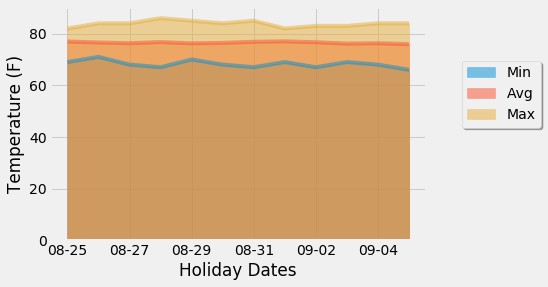

In [58]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind="area", stacked=False)
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
plt.ylabel("Temperature (F)")
plt.show()